# Price model prediction - Flight Tickets 

Avec une industrie du transport aérien en constante évolution, la nécessité de prédire avec précision les prix des billets d'avion se fait de plus en plus pressante. Cependant, il n'existe pas une application dédiée sur le marché raison pour laquelle ce projet s'engage à combler cette lacune en exploitant les avancées du machine learning pour développer un modèle prédictif novateur, permettant l'optimisation des revenus pour les compagnies aériennes et la fourniture d'informations fiables aux voyageurs.

![](https://traveltomorrow.com/wp-content/uploads/2023/04/airbus350-1000-v4-cloudscape-01_600x337.jpeg)

# 1. Déscription et selection de la base de données

Chaque ligne des données collectées représente des vols au départ d'un ensemble spécifique des sept aéroports les plus fréquentés en Inde. Les informations concernent le code du vol, la date du voyage, la compagnie aérienne, la classe, l'heure de départ, la source, l'heure d'arrivée, la destination, la durée, le nombre total d'escales, les jours restants (jours entre la réservation et la date du vol) et le prix.

Ce base de données a été retrouvé sur [kaggle](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares?select=Cleaned_dataset.csv
) 


In [1]:
# Libraries
from zipfile import ZipFile
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from yellowbrick.regressor import ResidualsPlot
import pickle

## 1.1. Data Analysis

In [2]:
# Extracting dataset
with ZipFile('C_dataset.csv.zip','r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
# Reading file
df = pd.read_csv('data/Cleaned_dataset.csv')
df.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [4]:
# Exploring data
print(df.shape)
df.info()

(452088, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_of_journey    452088 non-null  object 
 1   Journey_day        452088 non-null  object 
 2   Airline            452088 non-null  object 
 3   Flight_code        452088 non-null  object 
 4   Class              452088 non-null  object 
 5   Source             452088 non-null  object 
 6   Departure          452088 non-null  object 
 7   Total_stops        452088 non-null  object 
 8   Arrival            452088 non-null  object 
 9   Destination        452088 non-null  object 
 10  Duration_in_hours  452088 non-null  float64
 11  Days_left          452088 non-null  int64  
 12  Fare               452088 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 44.8+ MB


In [5]:
# Analyzing null elements
df.isna().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

In [6]:
# Analyzing duplicates
df.duplicated().sum()

6722

In [7]:
df[df.duplicated()]

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
19211,2023-01-16,Monday,Vistara,UK-627,Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,29.9167,1,11117
19321,2023-01-16,Monday,Vistara,UK-627,Premium Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,31.5833,1,20084
19323,2023-01-16,Monday,Vistara,UK-627,Premium Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,33.5000,1,20084
19633,2023-01-17,Tuesday,Vistara,UK-929,Economy,Delhi,After 6 PM,2+-stop,After 6 PM,Bangalore,21.9167,2,15473
19670,2023-01-17,Tuesday,Vistara,UK-627,Premium Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,29.9167,2,15196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451999,2023-03-06,Monday,Air India,AI-482,Economy,Ahmedabad,12 PM - 6 PM,1-stop,Before 6 AM,Chennai,10.4167,50,11646
452010,2023-03-06,Monday,Vistara,UK-918,Economy,Ahmedabad,Before 6 AM,1-stop,12 PM - 6 PM,Chennai,11.2500,50,15856
452011,2023-03-06,Monday,Vistara,UK-918,Economy,Ahmedabad,Before 6 AM,1-stop,12 PM - 6 PM,Chennai,11.2500,50,15856
452085,2023-03-06,Monday,Vistara,UK-918,Business,Ahmedabad,Before 6 AM,1-stop,12 PM - 6 PM,Chennai,11.2500,50,69254


In [8]:
df[(df['Flight_code']=='UK-627') & (df['Class']=='Economy') & (df['Duration_in_hours']==29.9167) & (df['Journey_day']=='Monday') & 
   (df['Date_of_journey']=='2023-01-16')]

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
19210,2023-01-16,Monday,Vistara,UK-627,Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,29.9167,1,11117
19211,2023-01-16,Monday,Vistara,UK-627,Economy,Delhi,12 PM - 6 PM,2+-stop,After 6 PM,Bangalore,29.9167,1,11117


After a review fo some duplicated elements, the information per line shows identical flights with the same details per line. This is completely normal as one person could have booked the flight the same day as another person. However, as our model will predict the price of a flight, duplicated elements might introduce biais in the model, so we will remove all duplicated elements.

In [9]:
# Erasing duplicated
df_r=df.drop_duplicates().reset_index(drop=True)
df_r.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


### * Customization and parsing

In [10]:
# Parsing dates 
df_r['Date_of_journey']=pd.to_datetime(df_r['Date_of_journey'])

# Customizing
df_r.rename(columns={'Fare': 'Price','Departure':'Dep_time','Arrival':'Arriv_time',
                     'Source':'Origin','Journey_day':'Journey_weekday'}, inplace=True)
df_r['Journey_month']=df_r['Date_of_journey'].dt.month
df_r['Journey_day']=df_r['Date_of_journey'].dt.day
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445366 entries, 0 to 445365
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date_of_journey    445366 non-null  datetime64[ns]
 1   Journey_weekday    445366 non-null  object        
 2   Airline            445366 non-null  object        
 3   Flight_code        445366 non-null  object        
 4   Class              445366 non-null  object        
 5   Origin             445366 non-null  object        
 6   Dep_time           445366 non-null  object        
 7   Total_stops        445366 non-null  object        
 8   Arriv_time         445366 non-null  object        
 9   Destination        445366 non-null  object        
 10  Duration_in_hours  445366 non-null  float64       
 11  Days_left          445366 non-null  int64         
 12  Price              445366 non-null  int64         
 13  Journey_month      445366 non-null  int32   

### 1.1. Analyzing distribution of categorical variables

In [14]:
### Useful dictionnaries
# Dictionary for Class
class_dict = {
    1 : "Economy",
    2 : "Business",
    3 : "Premium Economy",
    4 : "First",
}

# Dictionnary for days in a week
days_dict={
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',  
    6:'Saturday',
    7:'Sunday',      
}

# Dictionnary for Origin countries
country_dict={
    1:'Delhi',
    2:'Mumbai',
    3:'Bangalore',
    4:'Hyderabad',
    5:'Chennai',
    6:'Kolkata',
    7:'Ahmedabad'
}

#### A. Distribution of Origin and Destination

In [11]:
print(df_r['Origin'].value_counts())
df_r['Destination'].value_counts()

Origin
Delhi        82481
Mumbai       79894
Bangalore    72668
Hyderabad    56054
Chennai      55659
Kolkata      54193
Ahmedabad    44417
Name: count, dtype: int64


Destination
Mumbai       81675
Delhi        76758
Bangalore    71603
Hyderabad    61775
Chennai      57060
Kolkata      53465
Ahmedabad    43030
Name: count, dtype: int64

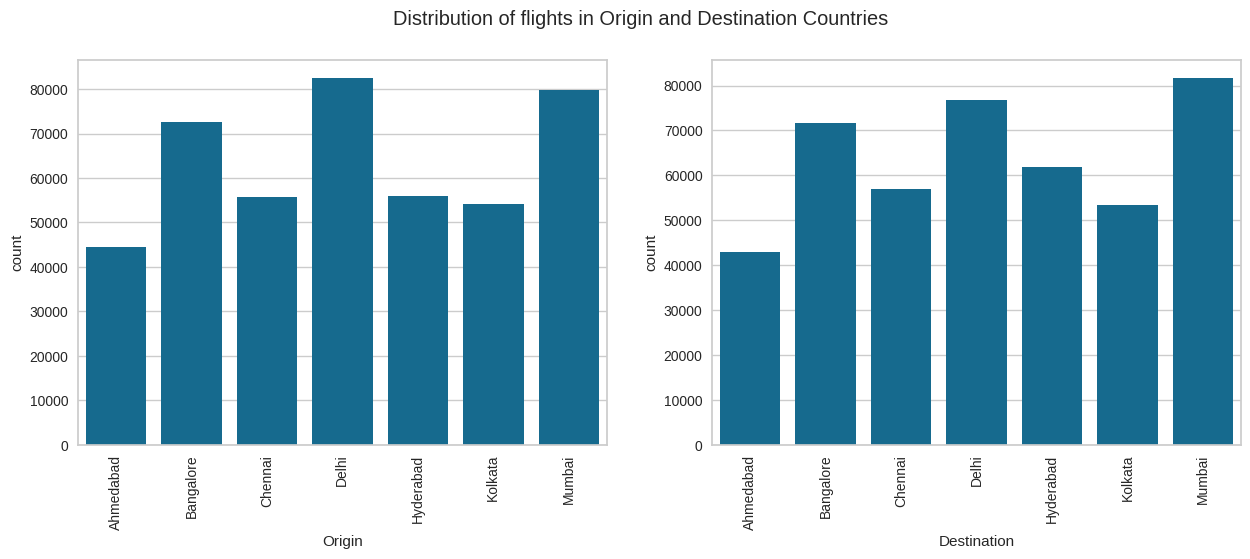

In [12]:
# Filter out Matplotlib FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.xticks(rotation=90)
sns.countplot(x='Origin',data=df_r, order=sorted(df_r['Origin'].unique()))
plt.subplot(1,2,2)
plt.xticks(rotation=90)
sns.countplot(x='Destination',data=df_r, order=sorted(df_r['Destination'].unique()))
plt.suptitle('Distribution of flights in Origin and Destination Countries')
plt.show()

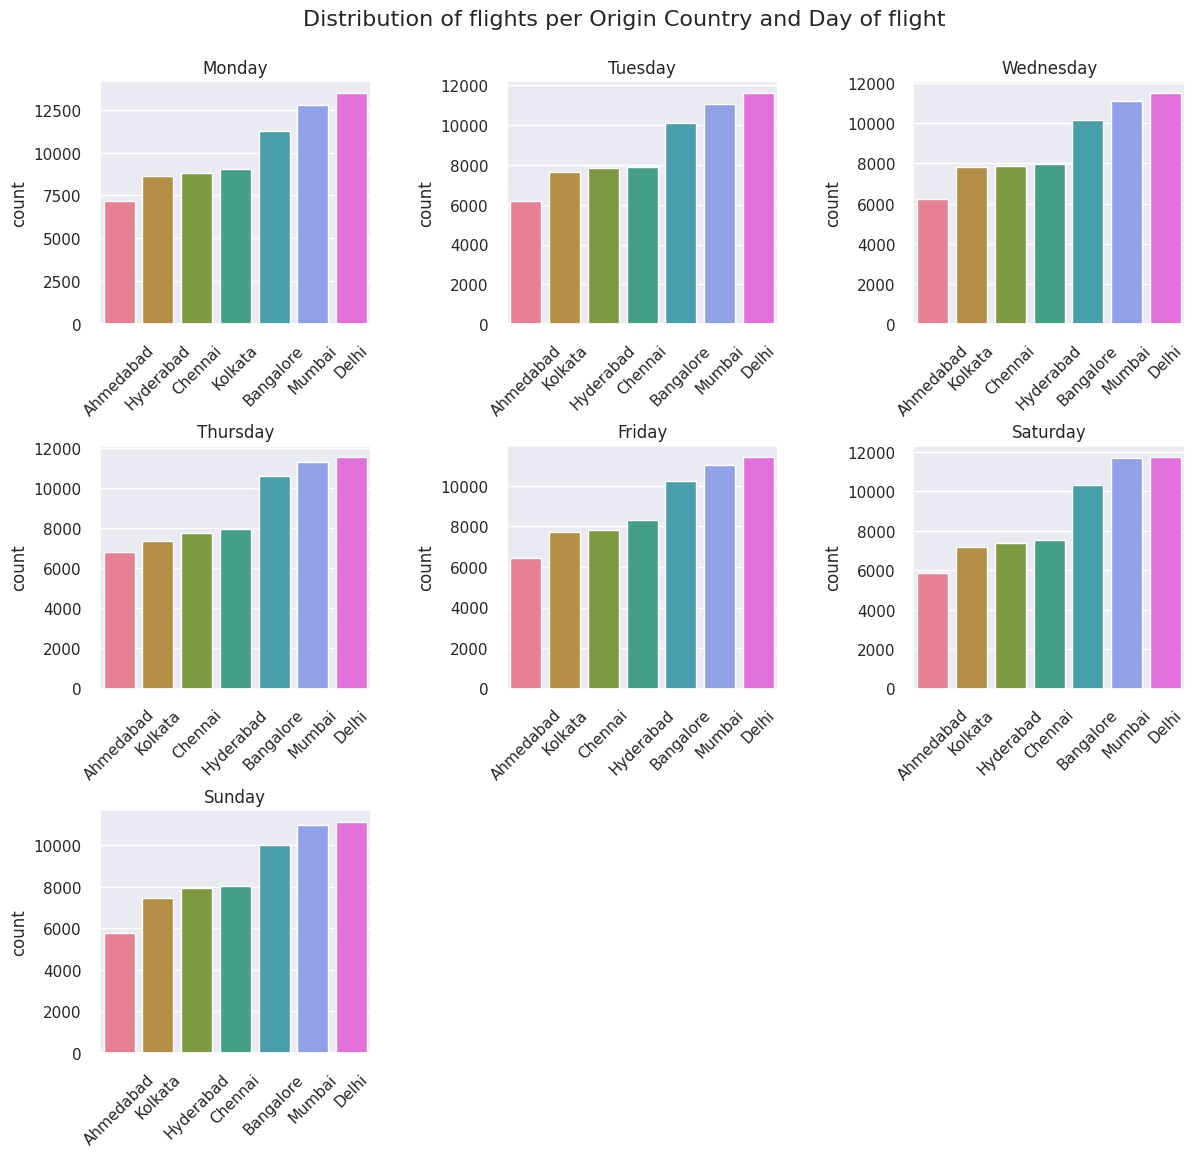

In [29]:
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(14,12))

for i in range(7):
    plt.subplot(3,3,i+1)
    origin_order = df_r[df_r['Journey_weekday'] == days_dict[i + 1]]['Origin'].value_counts().index[::-1]
    sns.countplot(x='Origin',data=df_r[df_r['Journey_weekday']==days_dict[i+1]],order=df_r[df_r['Journey_weekday']==days_dict[i+1]]['Origin'].value_counts().index[::-1],
                  palette=sns.color_palette("husl", n_colors=len(origin_order)))
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.title(days_dict[i+1])
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.92)
plt.suptitle('Distribution of flights per Origin Country and Day of flight',fontsize=16)
plt.show()

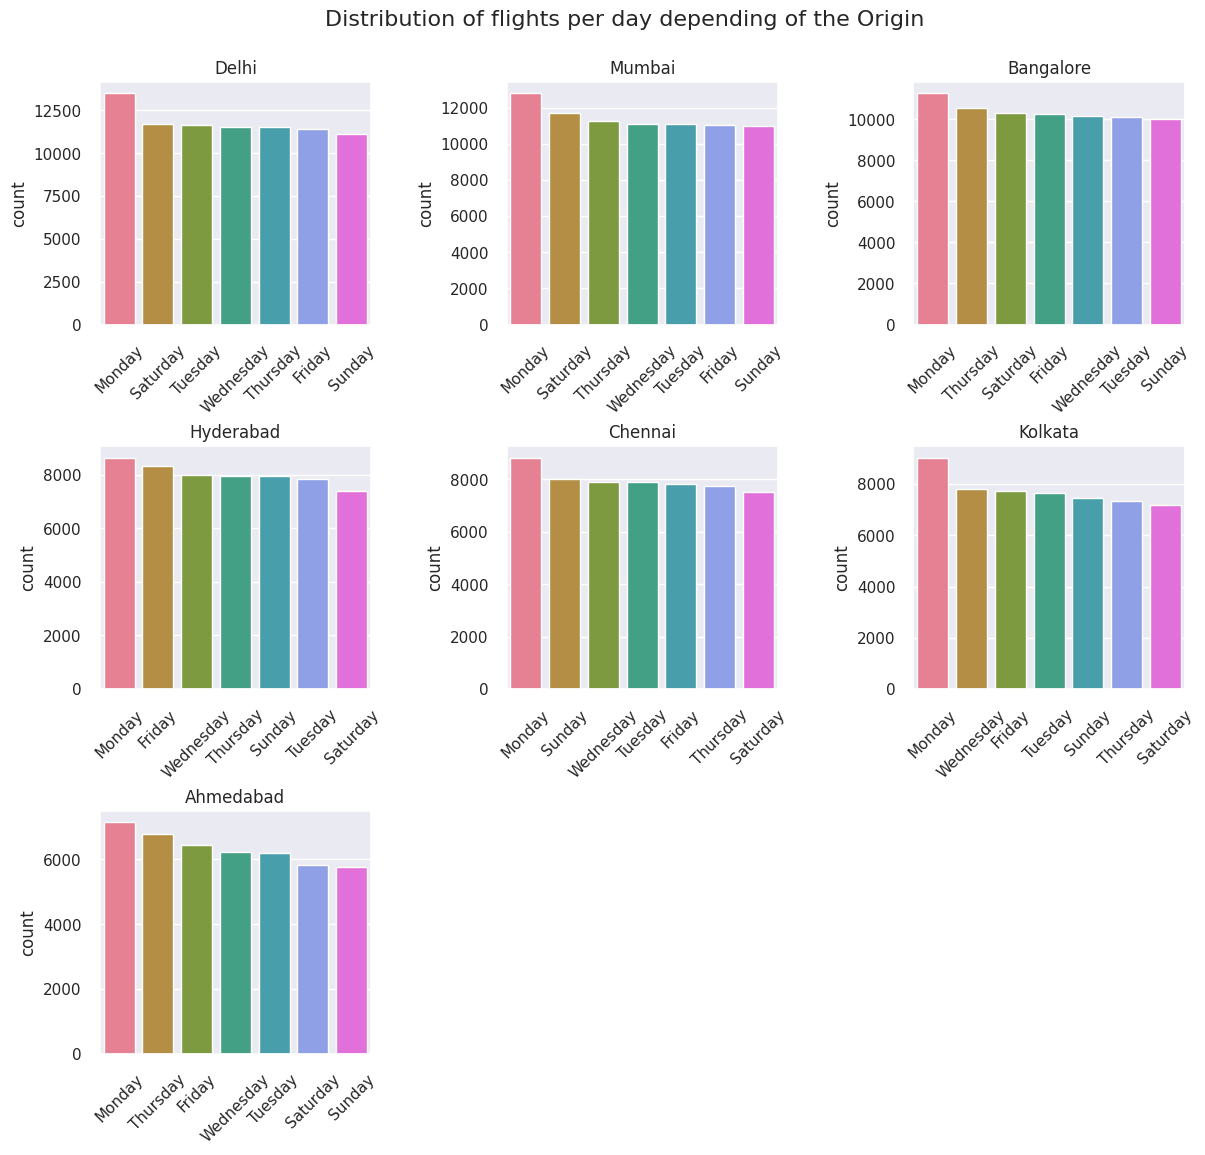

In [42]:
plt.figure(figsize=(14,12))
sns.set_theme()
for i in range(7):
    plt.subplot(3,3,i+1)
    sns.countplot(x='Journey_weekday',data=df_r[df_r['Origin']==country_dict[i+1]],
                  order=df_r[df_r['Origin']==country_dict[i+1]]['Journey_weekday'].value_counts().index,
                  palette="husl")
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.title(country_dict[i+1])
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.92)
plt.suptitle('Distribution of flights per day depending of the Origin',fontsize=16)
plt.show()

#### Some conclusions:
The majority of the flights are bought for a monday, there are not so much variations about the other days. However, if we take into account the Origin Country, in some of them people prefer to book a flight in Saturday, Thursday or Wednesday (as second option after monday)

#### B. Distribution of Airline and Class

In [43]:
df_r['Class'].value_counts()

Class
Economy            248323
Business           126535
Premium Economy     70364
First                 144
Name: count, dtype: int64

In [44]:
df_r.groupby(['Airline', 'Class']).size().reset_index(name='Count')

,Airline,Class,Count
0,Air India,Business,52256
1,Air India,Economy,66005
2,Air India,First,144
3,AirAsia,Economy,15764
4,AkasaAir,Economy,2230
5,AllianceAir,Economy,393
6,GO FIRST,Economy,10786
7,Indigo,Economy,65659
8,SpiceJet,Economy,5863
9,StarAir,Economy,62


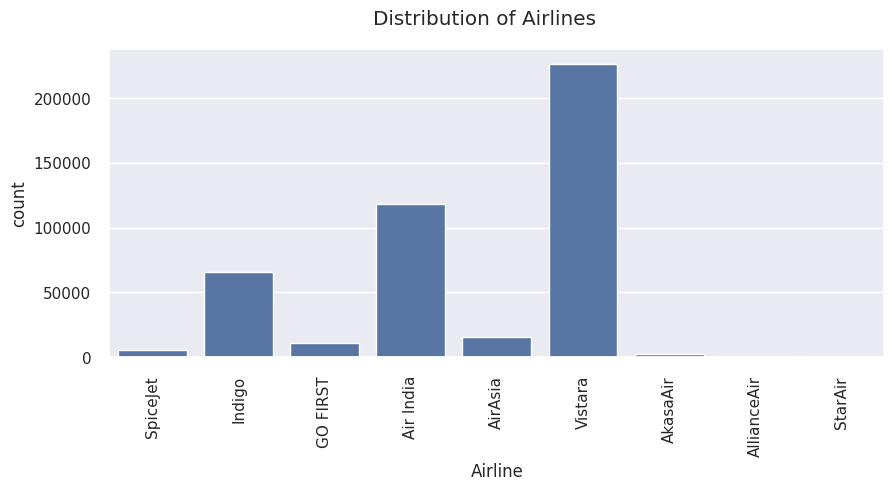

In [47]:
plt.figure(figsize=(10,4))
plt.suptitle('Distribution of Airlines')
sns.countplot(x='Airline',data=df_r)
plt.xticks(rotation=90)
plt.show()

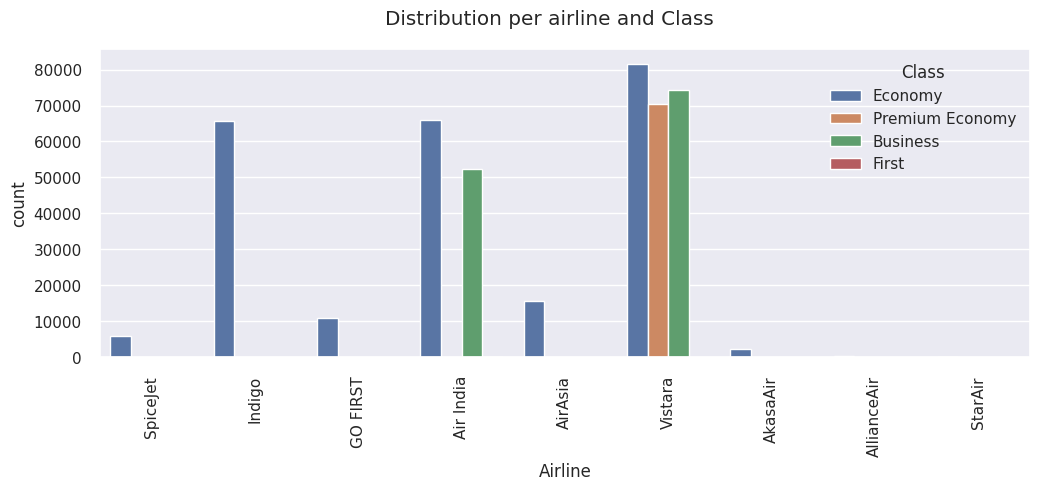

In [48]:
plt.figure(figsize=(12,4))
plt.suptitle('Distribution per airline and Class')
#plt.subplot(1,2,1)
sns.countplot(x='Airline', hue='Class', data=df_r)
plt.xticks(rotation=90)
#plt.subplot(1,2,2)
#sns.countplot(x='Class', data=df_r)
#plt.xticks(rotation=90)
plt.show()

### 1.2. Analyzing distribution of some numerical variables

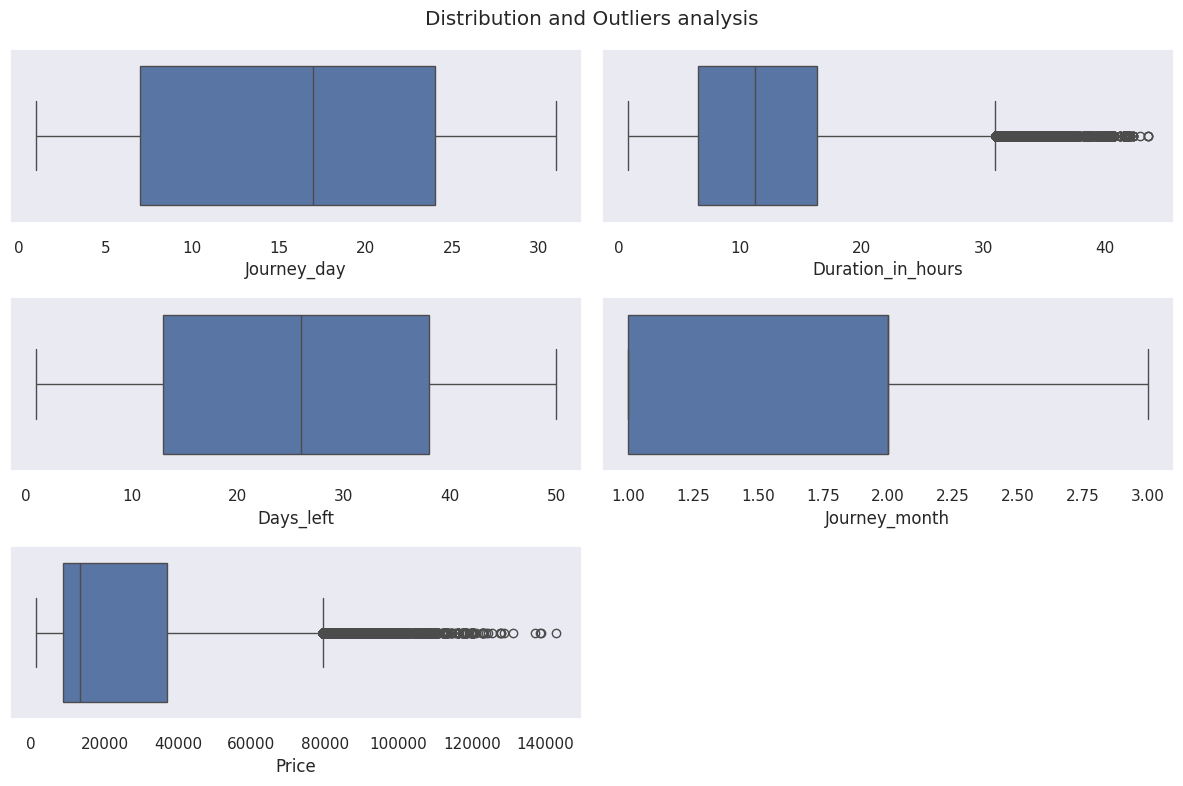

In [49]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
numeric_columns = ['Journey_day', 'Duration_in_hours', 'Days_left', 'Journey_month','Price']

# Analyzing each numeric column to evaluate outliers
plt.figure(figsize=(12, 8))
plt.suptitle('Distribution and Outliers analysis')
sns.set(style="dark")  # Set the style of the seaborn plot

for i in range(len(numeric_columns)):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df_r[numeric_columns[i]])

plt.tight_layout()

plt.show()

A quick review let us know we need to see carefully two variables: "Duration in hours" and "Price" as there are some points far from the media.
However, as there are 4 different classes included in the price analysis, those outliers are understable. 
To see if these points are really outliers we need to analyze separately. 

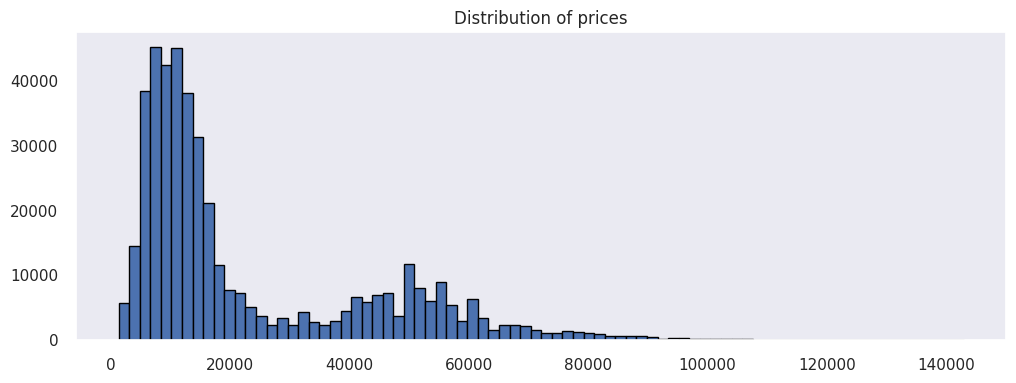

In [50]:
# Analysis of distribution of prices (Total)
plt.figure(figsize=(12,4))
plt.hist(x=df_r['Price'], bins=80, edgecolor='black')
plt.title('Distribution of prices')
plt.show()

#### * Analyzing the distribution of prices per class

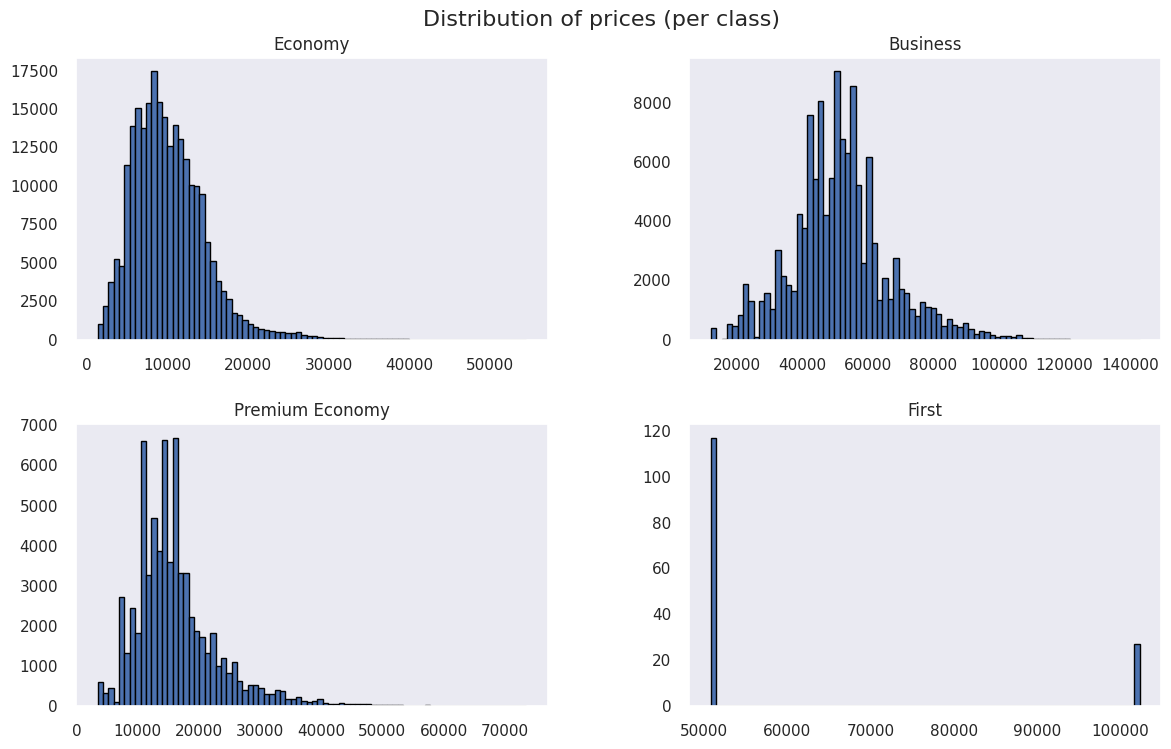

In [51]:
# Analysis of distribution of prices (per class)

plt.figure(figsize=(14,8))
for i in range(len(class_dict)):
    plt.subplot(2,2,i+1)
    plt.hist(x=df_r['Price'][df_r['Class']==class_dict[i+1]], bins=80, edgecolor='black')
    plt.xlabel('')
    plt.title(class_dict[i+1])
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.92)
plt.suptitle('Distribution of prices (per class)',fontsize=16)
plt.show()

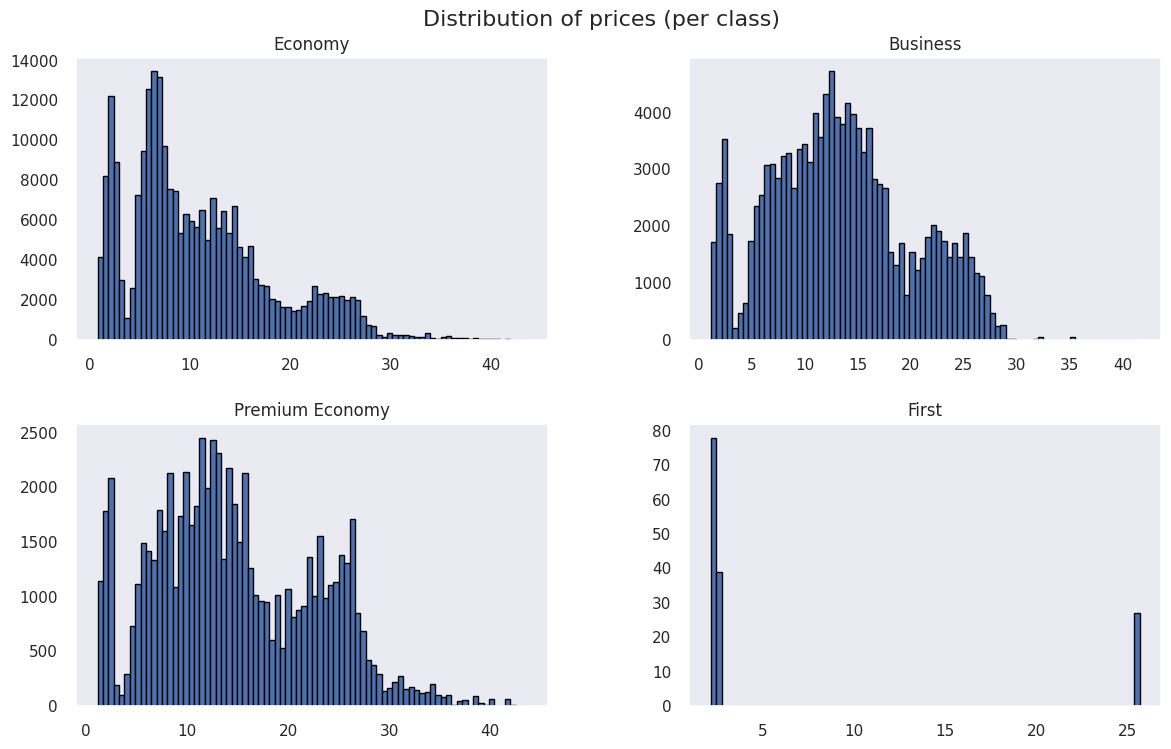

In [55]:
plt.figure(figsize=(14,8))
for i in range(len(class_dict)):
    plt.subplot(2,2,i+1)
    plt.hist(x=df_r['Duration_in_hours'][df_r['Class']==class_dict[i+1]], bins=80, edgecolor='black')
    plt.xlabel('')
    plt.title(class_dict[i+1])
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.92)
plt.suptitle('Distribution of prices (per class)',fontsize=16)
plt.show()

As we saw the distribution of prices are different depending on the classes. So to evaluate if we have outliers, we must to make a deeper analysis taking into account the class, the journey_month, the total_stops and the duration in hours.  
It is important to consider the possible outliers represents real points as this data was obtained scrapping.
So before the modelisation we will separate the data per class and we will attribute a model according to its distribution and better performance

In [66]:
df_r1 = df_r.copy()
df_Economy = df_r1[df_r1['Class']=='Economy']

## 2. Modelisation

### 2.1. Dummies and encoding
As all out features are not numerical we must encode those features. The flight code represents important information, but as there are several unique values in this column we are going to use a Label encoder and for the other features hot-encodding.  
Looking at the price, we can notice there is no uniform distribution, so it could be better to apply a log function on it.

In [68]:
# Label encoder
df_Economy.loc[:, 'flight_code_encoded'] = LabelEncoder().fit_transform(df_Economy['Flight_code'])

In [69]:
# Log function
df_Economy.loc[:, 'Price'] = np.log1p(df_Economy['Price'])


In [70]:
# Getting dummies 
dfE_not_dum = df_Economy.drop(columns=['Date_of_journey','Journey_weekday','Airline','Class','Origin','Dep_time','Total_stops','Arriv_time','Destination'], axis=1)
dfE_dum = df_Economy[['Journey_weekday','Airline','Origin','Dep_time','Total_stops','Arriv_time','Destination']]
dfE_encoded = pd.get_dummies(dfE_dum, columns=['Journey_weekday','Airline','Origin','Dep_time','Total_stops','Arriv_time','Destination'], dtype='int')


In [71]:
# Final dataframe
dfE_final = dfE_not_dum.join(dfE_encoded, how='inner')
dfE_final = dfE_final.drop(columns=['Flight_code'],axis=1)
dfE_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248323 entries, 0 to 445297
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Duration_in_hours          248323 non-null  float64
 1   Days_left                  248323 non-null  int64  
 2   Price                      248323 non-null  float64
 3   Journey_month              248323 non-null  int32  
 4   Journey_day                248323 non-null  int32  
 5   flight_code_encoded        248323 non-null  int64  
 6   Journey_weekday_Friday     248323 non-null  int64  
 7   Journey_weekday_Monday     248323 non-null  int64  
 8   Journey_weekday_Saturday   248323 non-null  int64  
 9   Journey_weekday_Sunday     248323 non-null  int64  
 10  Journey_weekday_Thursday   248323 non-null  int64  
 11  Journey_weekday_Tuesday    248323 non-null  int64  
 12  Journey_weekday_Wednesday  248323 non-null  int64  
 13  Airline_Air India          248323 

#### * Analyzing correlation between variables

Top 5 Correlations:
Journey_month        Days_left              0.885079
Airline_Vistara      flight_code_encoded    0.779301
Price                Duration_in_hours      0.390478
flight_code_encoded  Duration_in_hours      0.349523
Airline_Air India    Duration_in_hours      0.323861
dtype: float64


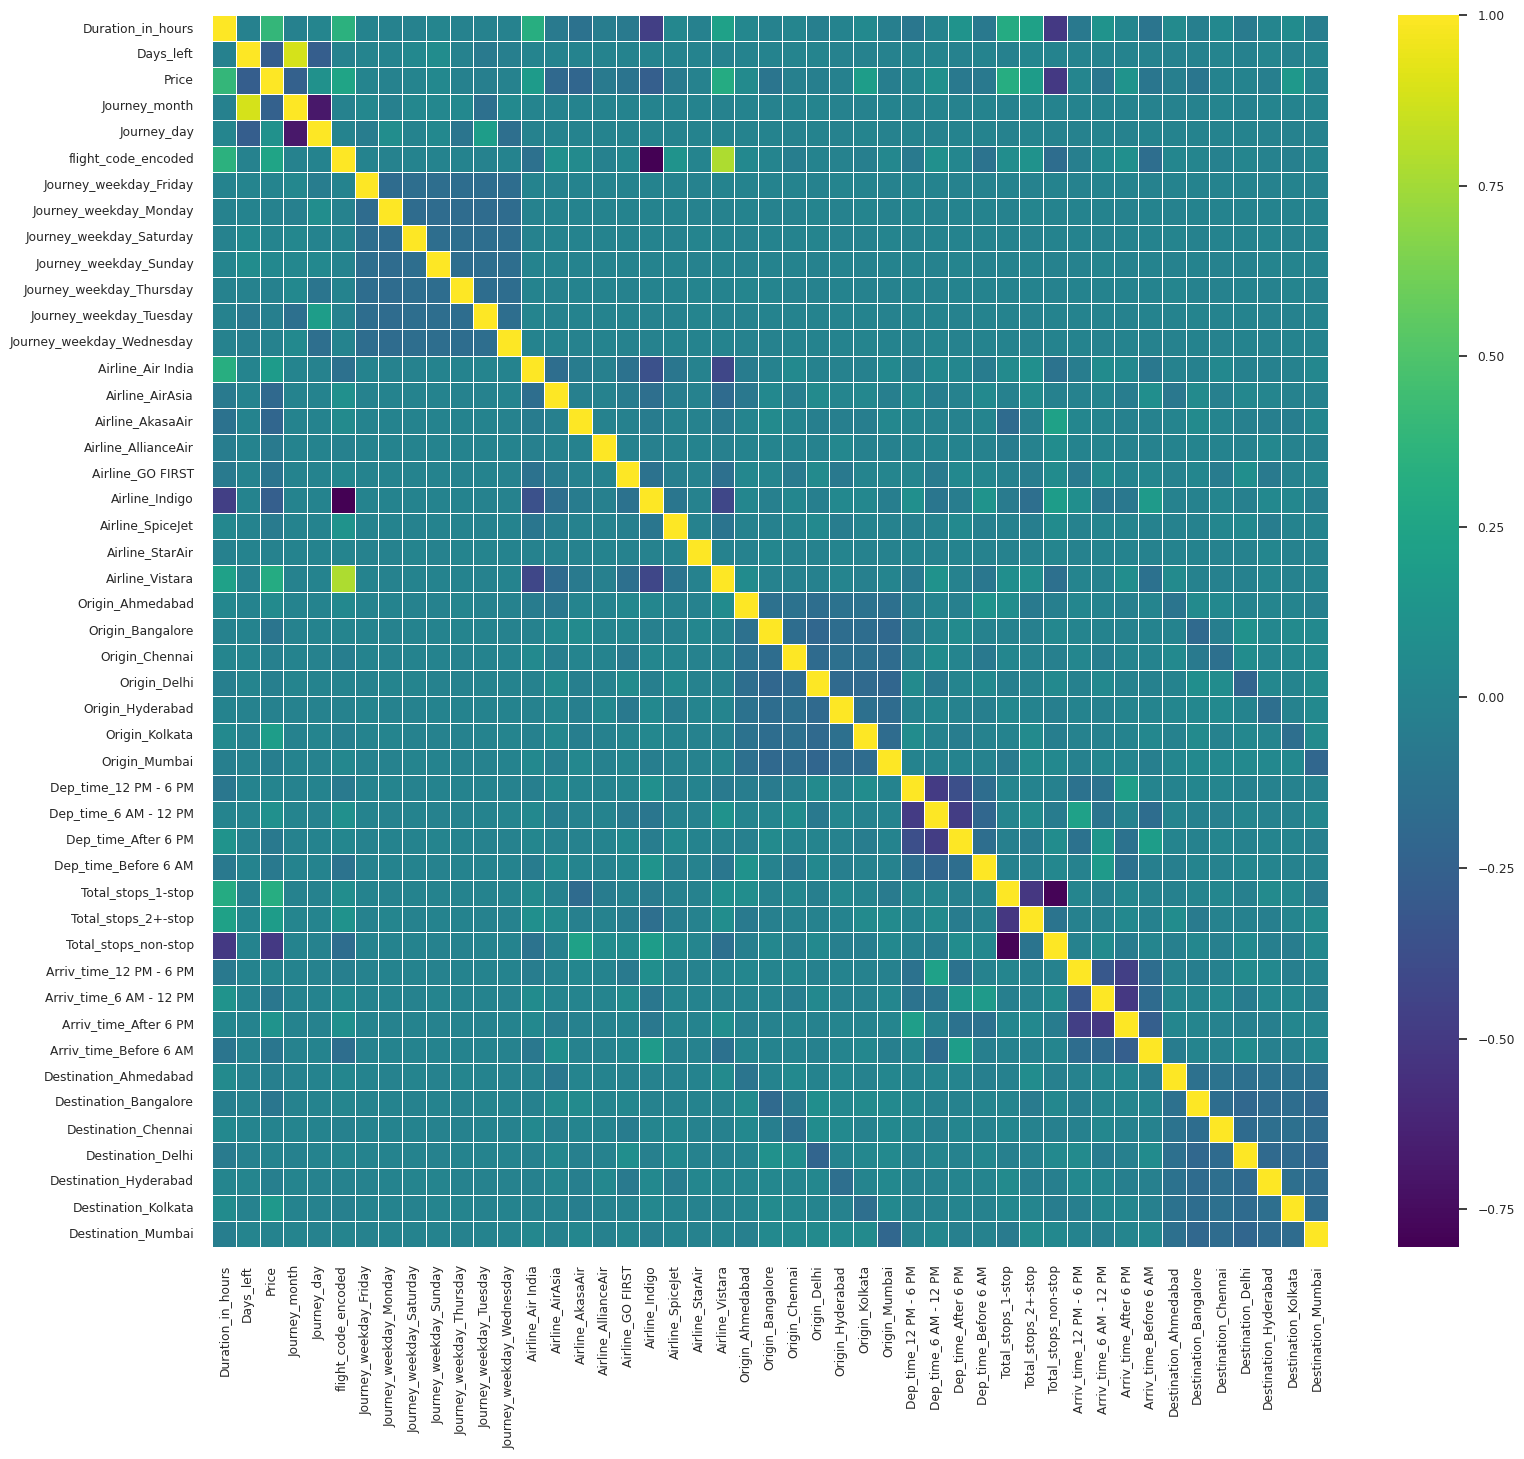

In [76]:
# Heatmapping
correlation_matrix = dfE_final.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 16))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, cmap="viridis", linewidths=.5)

sns.set(font_scale=0.8)

# Find the top N correlated variable pairs
N = 5
# Extract the upper triangle of the correlation matrix (excluding the diagonal)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
# Get the top N variable pairs with the highest correlation
top_correlations = upper_triangle.unstack().sort_values(ascending=False).head(N)

print("Top 5 Correlations:")
print(top_correlations)

### 2.2. Test and Train

In [72]:
X = dfE_final.drop('Price', axis=1)
y = dfE_final['Price']

In [77]:
# Selecting relevant variables
selection = ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

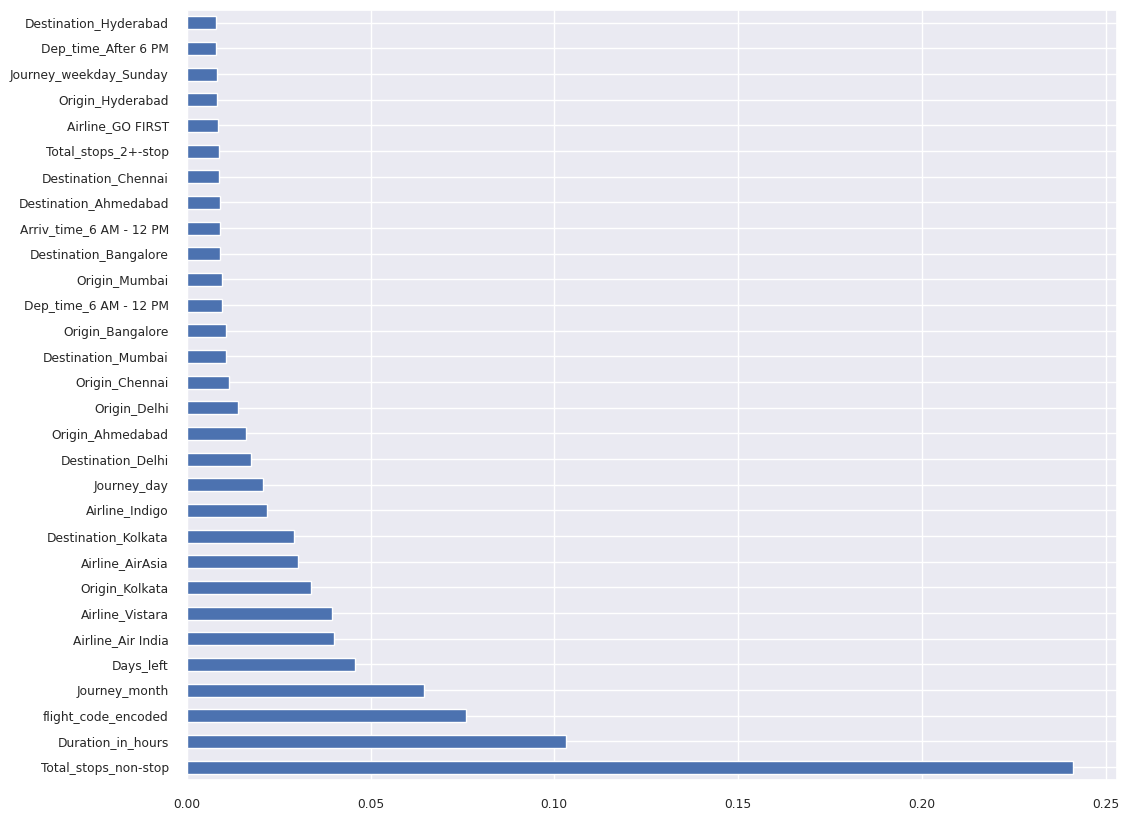

In [78]:
plt.figure(figsize=(12,10))
import_features = pd.Series(selection.feature_importances_,index=X.columns)
import_features.nlargest(30).plot(kind='barh')
plt.show()

In [98]:
# Preparing train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=180, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((198658, 46), (49665, 46), (198658,), (49665,))

In [80]:
modelE = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.8,learning_rate=0.1, max_depth=30 ,alpha=0.1 , n_estimators=50)

In [81]:
cv_scores_E = cross_val_score(modelE, X, y, cv=5, scoring='r2')
print("Cross-Validation Scores:", cv_scores_E)
print("Mean R2 Score:", cv_scores_E.mean())

Cross-Validation Scores: [0.37314392 0.64340024 0.68671055 0.3603494  0.57512544]
Mean R2 Score: 0.5277459097036725


In [88]:
# Hyperparameters
# Create a pipeline with the XGBoost model
pipeline = Pipeline([
    ('model', modelE)
])

# Define the hyperparameters to search
param_grid = {
    'model__n_estimators': [20, 50],           
    'model__learning_rate': [0.01, 0.1, 0.2],       
    'model__max_depth': [10, 20, 30],                             
    'model__colsample_bytree': [0.3, 0.5, 0.8],     
    }

# Use R^2 as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding R^2 score
print("Best Parameters: ", grid_search.best_params_)
print("Best MSE Score: ", -grid_search.best_score_)

Best Parameters:  {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 20, 'model__n_estimators': 50}
Best MSE Score:  0.019307536278037822


In [89]:
# Final model
modelE1 = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.8,learning_rate=0.2, max_depth=20 ,alpha=0.1 , n_estimators=50)

In [90]:
modelE1.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, ...)

In [94]:
cv_scores_mse = cross_val_score(modelE1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Individual Fold Scores (Negative Mean Squared Error)
print("Individual Fold Scores:", cv_scores_mse)

# Mean Squared Error Across Folds
mean_mse = np.mean(cv_scores_mse)
print("Mean Squared Error Across Folds:", mean_mse)

# Positive Mean Squared Error (for interpretation purposes)
positive_mean_mse = -mean_mse
print("Positive Mean Squared Error:", positive_mean_mse)

Individual Fold Scores: [-0.01983993 -0.01931468 -0.01909742 -0.01891324 -0.01937241]
Mean Squared Error Across Folds: -0.019307536278037822
Positive Mean Squared Error: 0.019307536278037822


## 3. Prediction

In [95]:
y_pred_logE = modelE1.predict(X_test)

# Evaluate the performance on the test set
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_logE))

# Back-transform the predictions to the original scale
y_predE = np.expm1(y_pred_logE)
y_testE_original_scale = np.expm1(y_test)

# Evaluate the performance on the original scale
rmse_original_scale = np.sqrt(mean_squared_error(y_testE_original_scale, y_predE))
mae_original_scale = mean_absolute_error(y_testE_original_scale, y_predE)
r2_original_scale = r2_score(y_testE_original_scale, y_predE)

print(f"RMSE on original scale: {rmse_original_scale}")
print(f"MAE on original scale: {mae_original_scale}")
print(f"R2 on original scale: {r2_original_scale}")

RMSE on original scale: 1596.9732994752974
MAE on original scale: 829.8689656636967
R2 on original scale: 0.8772481479466505


#### * Visualization of Residuals

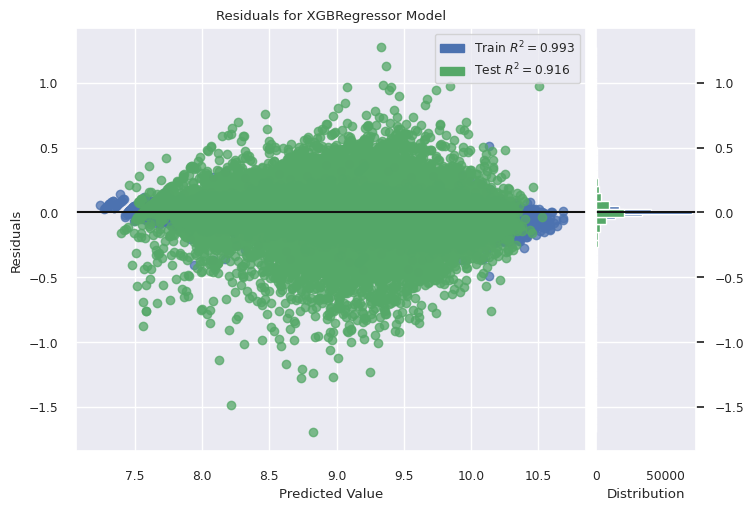

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [96]:
visualizer = ResidualsPlot(modelE1, hist=True, qqplot=False)
visualizer.fit(X_train, y_train)  # Fitting the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluating the model on the test data with original-scale y
visualizer.show()

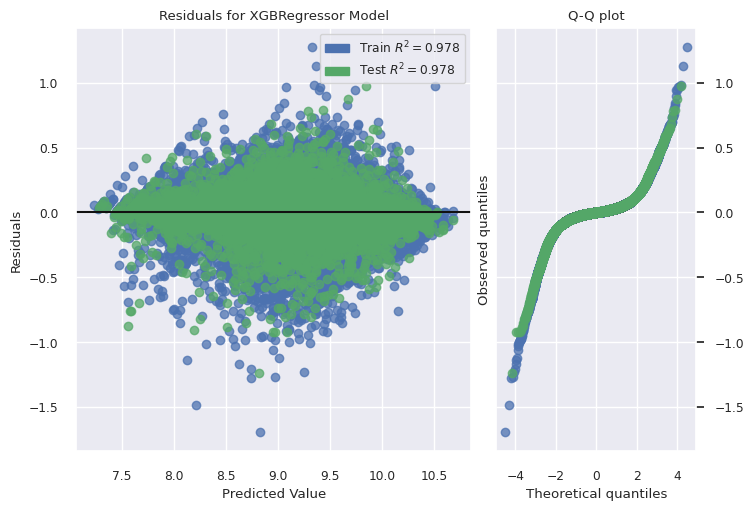

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [99]:
visualizer = ResidualsPlot(modelE1, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)  # Fitting the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluating the model on the test data with original-scale y
visualizer.show()

## 4. Saving model

In [100]:
with open('project/trained_model_E.pkl', 'wb') as model_file:
    pickle.dump(modelE1, model_file)